### Описание задачи аналитика:

Продукт: развлекательное приложение Procrastinate Pro+.

Задача: определить причины убытков и дать рекомендации для выхода в плюс.

Данные:

Сегодня 1 ноября 2019 года.

Пользователь должен окупаться не поздне двух недель после привлечения.

Таблица visits_log_short (лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27):

    * User Id — уникальный идентификатор пользователя
    * Device — категория устройства пользователя
    * Session start — дата и время начала сессии
    * Session End — дата и время окончания сессии
    * Channel — идентификатор рекламного источника, из которого пришел пользователь
    * Region - страна пользователя

Таблица orders_log_short (выгрузка покупок новых пользователей с 2019-05-01 по 2019-10-27):

    *  User Id — уникальный id пользователя, который сделал заказ
    * Event Dt — дата и время покупки
    * Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг с 2019-05-01 по 2019-10-27):

    * Channel — идентификатор рекламного источника
    * Dt — дата
    * Costs — затраты на этот рекламный источник в этот день

## Шаг 1. Подготовка данных к анализу

Загрузим необходимые библиотеки, откроем данные и изучим их:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.3f}'.format)

visits=pd.read_csv('/datasets/visits_info_short.csv')
orders=pd.read_csv('/datasets/orders_info_short.csv')
costs=pd.read_csv('/datasets/costs_info_short.csv')

for df in (visits,orders,costs):
    display(df.head()), display(df.info()), display (f'Дубликатов {df.duplicated().sum()}'), print('*'*50)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

'Дубликатов 0'

**************************************************


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.990
1,174361394180,2019-05-01 12:24:04,4.990
2,529610067795,2019-05-01 11:34:04,4.990
3,319939546352,2019-05-01 15:34:40,4.990
4,366000285810,2019-05-01 13:59:51,4.990


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

'Дубликатов 0'

**************************************************


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.300
1,2019-05-02,FaceBoom,78.100
2,2019-05-03,FaceBoom,85.800
3,2019-05-04,FaceBoom,136.400
4,2019-05-05,FaceBoom,122.100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

'Дубликатов 0'

**************************************************


Видим, что в данных нет пропусков, отсутствуют дубликаты.
Приведем названия столбцов к "змеиному регистру":

In [3]:
for df in (visits,orders,costs):
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]

Поменяем формат данных в столбцах с датами:

In [4]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
visits

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,UK,PC,LeapBob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,France,PC,lambdaMediaAds,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,Germany,PC,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,Germany,Mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


Данные предобработаны. Перейдем к обозначению необходимых функций и проведению анализа.

## Шаг 2. Определение функций для расчета и анализа LTV, ROI, удержания и конверсии

Зададим функции ддя расчета и анализа.

get_profiles() - функция для создания пользовательских профилей

In [5]:
def get_profiles(sessions, orders,ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

     # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    # добавляем информацию о количестве сделанных заказов по каждому пользователю и сумму покупок
    orderss=orders.pivot_table(index='user_id', values = 'revenue',aggfunc=['count','sum'])\
        .reset_index(drop=False)
    orderss.columns=['user_id','revenue_count','revenue_sum']
     
    profiles=profiles.merge(orderss, on = 'user_id', how='left')
    profiles['revenue_count'] = profiles['revenue_count'].fillna(0)
    profiles['revenue_sum'] = profiles['revenue_sum'].fillna(0)
   

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

get_retention()-функция для расчёта удержания
Retention Rate или Удержание показывает, сколько пользователей из когорты относительно их первоначального числа вернулись, т.е. воспользовались продуктом.

Retention Rate = (Кол-во активных пользователей на текущий день)/(Количество активных пользователей на первый день)

In [6]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


get_conversion()-функция для расчёта конверсии
Conversion Rate  или Конверсия показывет % пользователей когорты, совершивших какое-л действие, например, оплату услуги.

Conversion Rate = (Кол-во новых покупателейна текущий день)/(Кол-во активных пользователей на первый день)

Коэффициент конверсии никогда не снижается, так как количество новых покупателей на текущий день считается накопительным итогом.

In [7]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

get_ltv()-функция для расчёта LTV и ROI

LTV, CAC и ROI - важные метрики юнит-экономики или экономики одного покупателя.

LTV -общая сумма денег, котрую один клиент приносит компании со всех своих покупок.

LTV = (Общая выручка на текущий день)/(Размер когорты)

CAC - инвестиции в маркетинг, приходящиеся на 1 клиента

CAC = (Расходы на рекламу)/(Размер когорты)

ROI - окупаемость инвестиций (на сколько % "окупились" клиенты)

ROI = (Общая выручка на текущий день)/(Расходы на рекламу) = LTV/CAC

In [8]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Для визуализации этих метрик напишем другие функции:

* filter_data() - функция для сглаживания датафрейма
* plot_retention() - функция для визуализации удержания
* plot_conversion() - функция для визуализации конверсии
* plot_ltv_roi() - функция для визуализации LTV и ROI

In [9]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df


In [10]:
def plot_retention(retention, retention_history, horizon, window=1):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()


In [11]:
def plot_conversion(conversion, conversion_history, horizon, window=1):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


In [12]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=1):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


Записали необходимые функции.
Переходим к анализу данных.

## Шаг 3. Исследовательский анализ данных

### Создание пользовательских профилей и определение max и  min дат их привлечения

Воспользуемся функцией get_profiles() для создания профилей.

In [13]:
profile = get_profiles(visits, orders,costs)
display(profile.head())


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,revenue_count,revenue_sum
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088,3.000,14.970
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107,0.000,0.000
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000,0.000,0.000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988,0.000,0.000
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.231,0.000,0.000


Установим момент и горизонт анализа данных.

In [14]:
observation_date = datetime(2019, 10, 27).date()  # момент анализа
horizon_days = 14  # горизонт анализа
last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1) # максимальная дата привлечения пользователей
min_day=profile['dt'].min()# минимальная дата привлечения пользователей 
print('Минимальная дата привлечения пользователей',min_day) 
print('Максимальная дата привлечения пользователей',last_suitable_acquisition_date )
print(f'Продолжительность периода анализа {(last_suitable_acquisition_date-min_day).days} дней и/или количество когорт')


Минимальная дата привлечения пользователей 2019-05-01
Максимальная дата привлечения пользователей 2019-10-14
Продолжительность периода анализа 166 дней и/или количество когорт


Для дальнейшего анализа возьмем только тех пользователей, которые привлечены в нужный для анализа период времени

In [15]:
profiles=profile.query('dt <=@last_suitable_acquisition_date')
len(profile)-len(profiles)

11243

При корректировке интервала дат привлечения база стала меньше на 11243 пользователя.


### Анализ пользователей по странам

Так как датафрейм "profiles" содержит данные об уникальных пользователях, то при определении числа платящих из каждой страны можно использовать по "user_id" как "count", так и "nunique".


In [42]:
region_profiles=profiles.groupby('region').agg({'user_id': 'nunique', 'payer':'sum', 'revenue_count':'sum', 'revenue_sum':'sum'})\
                .sort_values( by = 'user_id', ascending = False).rename(columns={'user_id':'count_user'})
region_profiles['payer_share']=(region_profiles['payer']/region_profiles['count_user'])
region_profiles['average_check']=region_profiles['revenue_sum']/region_profiles['revenue_count']
region_profiles=region_profiles.drop(columns =['payer','revenue_count','revenue_sum'])
region_profiles.style.format({'payer_share': '{:.2%}'})

,count_user,payer_share,average_check
region,,,
United States,92454,6.88%,5.364000
UK,16251,3.96%,5.534953
France,16185,3.78%,5.366886
Germany,13875,4.09%,5.280154


Видим, что наибольшее количество пользователей сервиса находится в United States, далее -  UK, с минимальной разницей -  France, последнее место у Germany. Причем по доле платящих пользователей лидирует United States, а после Germany,UK,France.

То есть можно увеличить объемы маркетинга на привлечение пользователей из Германии, так как доля платящих пользователей у них выше, чем у UK,France.

После добавления критерия "средний чек" видим, что наибольшие покупки в приложении делают жители UK, потом France, United States. Жители Германии делают частые, но маленькие покупки 5,28 у.е. 

п.с. Считаю необходимым добавить параметр "средний чек" в дальнейшем анализе, так как стоит вопрос "разобраться, почему убытки". А это процесс в 2 стороны: сокращать расходы (для этого выявим наиболее затратные статьи) и увеличивать прибыль (здесь поможет средний чек, кол-во клиентов).

### Анализ пользователей по устройствам

In [17]:
device_profiles=profiles.groupby('device').agg({'user_id': 'nunique', 'payer':'sum', 'revenue_count':'sum', 'revenue_sum':'sum'})\
               .sort_values( by = 'user_id', ascending = False).rename(columns={'user_id':'count_user'})
device_profiles['user_share']=(device_profiles['count_user']/profiles['user_id'].nunique())
device_profiles['payer_share']=(device_profiles['payer']/device_profiles['count_user'])
device_profiles['average_check']=device_profiles['revenue_sum']/device_profiles['revenue_count']
device_profiles=device_profiles.drop(columns =['payer','revenue_count','revenue_sum'])
device_profiles

,count_user,user_share,payer_share,average_check
device,,,,
iPhone,50371,0.363,0.062,5.359
Android,32374,0.233,0.058,5.392
PC,28197,0.203,0.050,5.393
Mac,27823,0.201,0.064,5.369


Видим, что большинство пользователей Procrastinate Pro+ заходит на ресурс с iPhone (36% от общего количества), с Android - 23% и по 20% с PC и Mac.

Однако по доле платящих пользователей лидирует Mac (6,4%), далее  - iPhone	(6,2%), Android (5,8%),PC (5%).

То есть чаще платят обладатели более дорогой техники (Mac и iPhone), чем более дешевой. Это можно объяснить их большими финансовыми возможностями, а также более сильным желанием справится с прокрастинацией.

Средний чек практически одинаков, поэтому тип устройства не влияет на размер чека. Можно говорить о том, что на всех устройствах пользователю одинаково удобно делать покупки, интерфейс на процесс покупки не влияет, технических ошибок в работе сайта на разных устройствах нет.

### Анализ пользователей по каналу привлечения

In [18]:
channel_profiles=profiles.groupby('channel').agg({'user_id': 'nunique', 'payer':'mean', 'revenue_count':'sum', 'revenue_sum':'sum'})\
                .rename(columns={'user_id':'count_user', 'payer':'payer_share'}) 
channel_profiles['user_share']=(channel_profiles['count_user']/profiles['user_id'].nunique())
channel_profiles['average_check']=channel_profiles['revenue_sum']/channel_profiles['revenue_count']
channel_profiles=channel_profiles.drop(columns =['revenue_count','revenue_sum'])
channel_profiles=channel_profiles.sort_values( by = 'user_share', ascending = False)
display(channel_profiles)

,count_user,payer_share,user_share,average_check
channel,,,,
organic,52627,0.021,0.379,5.375
FaceBoom,26736,0.122,0.193,5.447
TipTop,17953,0.097,0.129,5.347
OppleCreativeMedia,7890,0.027,0.057,5.409
LeapBob,7875,0.030,0.057,5.350
WahooNetBanner,7832,0.053,0.056,5.350
RocketSuperAds,4142,0.080,0.030,5.355
MediaTornado,4081,0.036,0.029,5.382
YRabbit,3990,0.038,0.029,5.328


Видим, что наибольшее число пользователей пришло органически (37,9%), 2- FaceBoom (19,3%), 3- TipTop(12,9%). Значит, что продукт очень полезный, пользователи рекомендуют его сами, рассказывают друзбям и знакомым, а для компании это бесплатно.

Однако по доле платящих пользователей лидирует FaceBoom, где платят 12,2% из всех привлеченных по этому каналу, 2- AdNonSense (11,1%), 3- lambdaMediaAds (10,6%), но доля этих каналов в общем привлечении мала, НО пользователи , пришедшие с этих каналов, в среднем платят больше.

Интересно,что пользователи , пришедшие органически, совершают покупки на ту же сумму, что и все остальные. 

Поэтому разрабатывать маркетинговые акции, направленные на покупки, для таких пользователей  особенно интересно и выгодно.

Сейчас получается, что пользователям в большинстве случаев хватает бесплатного функционала. Поэтому маркетологам необходимо подумать над дополнительными платными функциями, которые будут интересны пользователям, пришедшим органически.

### Вывод 

Несмотря на то, что на календаре 1 ноября 2019 года, данные в базе содержат информацию с 1.05.2019 по 27.10.2019,а  горизонт анализа 14 дней, то минимальная дата привлечения пользователей 2019-05-01, максимальная дата привлечения пользователей 2019-10-14.
Из информации содержщейся в созданной базе данных по пользователям profiles выводим:
* наибольшее количество пользователей сервиса находится в United States, далее -  UK, с минимальной разницей -  France, последнее место у Germany. Причем по доле платящих пользователей лидирует United States, а после Germany,UK,France.
* большинство пользователей Procrastinate Pro+ заходит на ресурс с iPhone (36% от общего количества), с Android - 23% и по 20% с PC и Mac. Однако по доле платящих пользователей лидирует Mac (6,4%), далее  - iPhone	(6,2%), Android (5,8%),PC (5%).
* наибольшее число пользователей пришло органически (37,9%), 2- FaceBoom (19,3%), 3- TipTop(12,9%).

Значит, что продукт очень полезный, пользователи рекомендуют его сами, рассказывают друзбям и знакомым, а для компании это бесплатно. Однако по доле платящих пользователей лидирует FaceBoom, где платят 12,2% из всех привлеченных по этому каналу, 2- AdNonSense (11,1%), 3- lambdaMediaAds (10,6%), но доля этих каналов в общем привлечении мала, но  пользователи , пришедшие с этих каналов, в среднем платят больше.

То есть можно увеличить объемы маркетинга на привлечение пользователей из Германии, так как доля платящих пользователей у них выше, чем у UK,France.

Также чаще платят обладатели более дорогой техники (Mac и iPhone), чем более дешевой. Это можно объяснить их большими финансовыми возможностями, а также более сильным желанием справится с прокрастинацией.

После добавления критерия "средний чек" видим, вид устройства на средний чек не влияет, в отличие от страны. В Европе средний чек выше, чем в США, но немцы делают частые, но маленькие покупки. Имеет смысл расширить число пользователей из Европы, так как средний чек у них выше (Англия, Франция).

Средний чек у органических пользователей такой же, как у всех остальных. Поэтому особенно выгодно увеличивать число платящих среди них.

Получается, что пользователям в большинстве случаев хватает бесплатного функционала. Поэтому маркетологам необходимо подумать над дополнительными платными функциями, которые будут интересны пользователям, пришедшим органически.

## Шаг 4. Маркетинг

### Общие расходы на маркетинг по источникам привлечения


Определим общие затраты на рекламу в анализируемом периоде с разбивкой по источникам.

In [19]:
costs=costs.query('dt <=@last_suitable_acquisition_date')

In [20]:
channel_cost=costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
channel_cost['costs_share']=channel_cost['costs']/channel_cost['costs'].sum()
print(f'Общая сумма расходов на рекламу составила у.е.',channel_cost['costs'].sum().astype(int))
channel_cost

Общая сумма расходов на рекламу составила у.е. 95805


,costs,costs_share
channel,,
TipTop,49074.300,0.512
FaceBoom,29774.800,0.311
WahooNetBanner,4712.400,0.049
AdNonSense,3656.100,0.038
OppleCreativeMedia,1971.750,0.021
RocketSuperAds,1742.325,0.018
LeapBob,1653.330,0.017
lambdaMediaAds,1462.400,0.015
MediaTornado,893.760,0.009


Видим, что большая часть расходов приходится TipTop (51,2%), далее FaceBoom (31,1%), WahooNetBanner	(4,9%). Остальные источники привлечения составляют незначительную долю в общей структуре расходов. Однако их нельзя исключать,так как необхоимо определить, окупается ли каждый из источников.

Посмотрим, как менялись расходы на рекламу со временем:

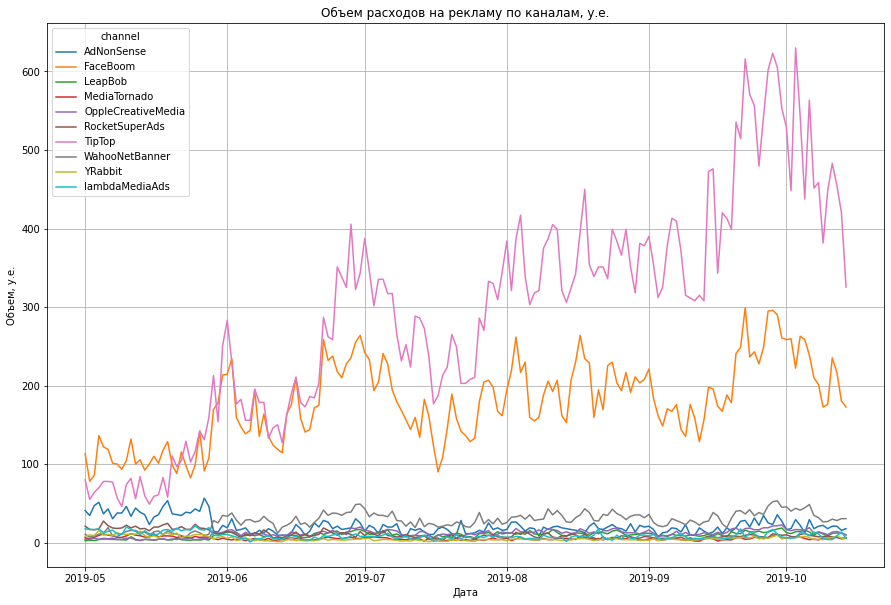

In [21]:
costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')\
.plot(grid=True, figsize=(15, 10), title='Объем расходов на рекламу по каналам, у.е.', ylabel='Объем, у.е.', xlabel='Дата');

Видим, что наибольший рост расходов приходится на TipTop и FaceBoom. Причем со временем расходы по каналу TipTop превысили расходы по FaceBoom. Расходы на рекламу по другим каналам остаются на одном уровне.

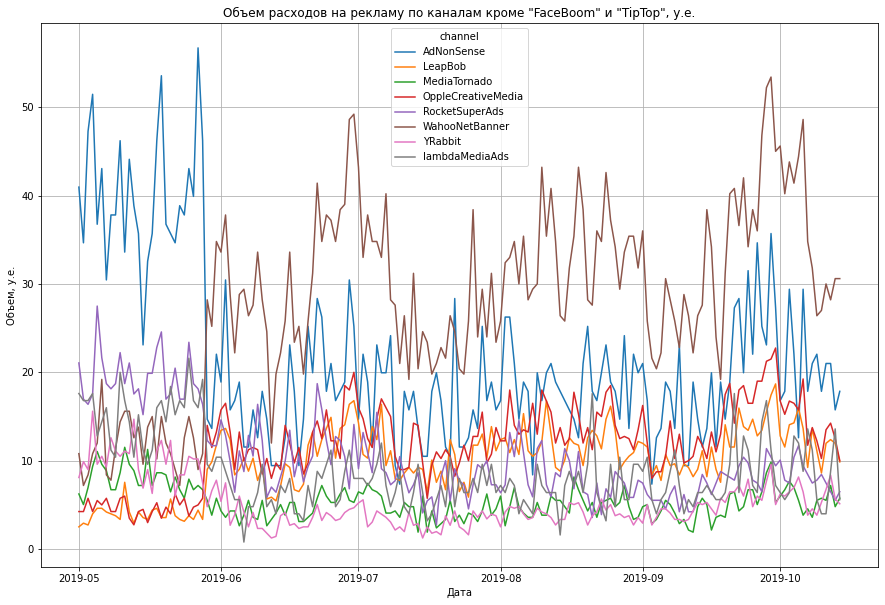

In [22]:
costs.query('channel != "FaceBoom" & channel !="TipTop"').pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')\
.plot(grid=True, figsize=(15, 10), title='Объем расходов на рекламу по каналам кроме "FaceBoom" и "TipTop", у.е.', ylabel='Объем, у.е.', xlabel='Дата');

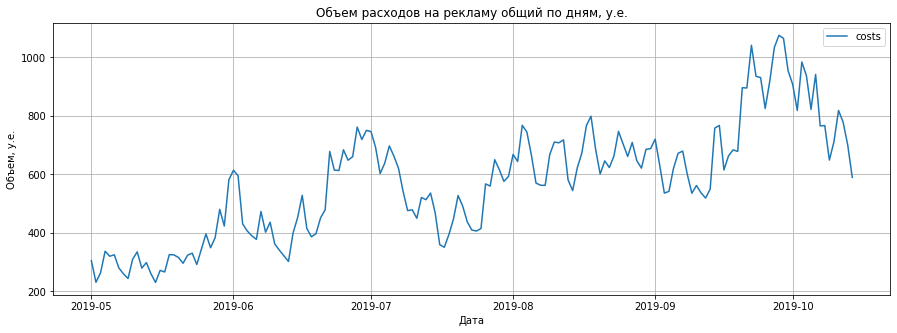

In [23]:
costs.pivot_table(index='dt', values='costs', aggfunc='sum')\
 .plot(grid=True, figsize=(15, 5),title='Объем расходов на рекламу общий по дням, у.е.', ylabel='Объем, у.е.', xlabel='Дата');

Видим, что в начале мая дневные расходы на рекламу были около 300 у.е., к октябрю они составляли более 1000 у.е. в день. 

In [24]:
c_cost=costs
c_cost['month']=pd.to_datetime(c_cost['dt']).dt.month
c_cost.pivot_table(index='month', values='costs', aggfunc='sum')

,costs
month,
5,9978.570
6,15090.045
7,16447.060
8,20657.870
9,22441.340
10,11190.850


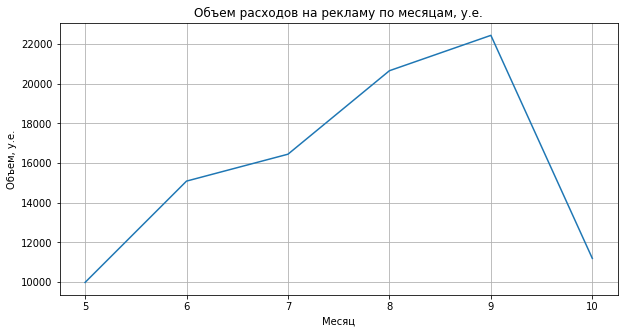

In [25]:
c_cost.pivot_table(index='month', values='costs', aggfunc='sum')\
        .plot(grid=True, figsize=(10, 5), title='Объем расходов на рекламу по месяцам, у.е.', ylabel='Объем, у.е.', xlabel='Месяц', legend=None);

Видим, что рекламные расходы от мая до сентября значительно увеличивались с 9978 у.е. до 22441 у.е., на 14.10.19 они составили 11190 у.е., то есть на уровне сентября.

Однако сравнивать каналы привлечения только по размеру расходов некорректно, так как необходимо рассчитать величину расходов, приходящуюся на одного привлеченного пользователя.

### Рекламные расходы на одного пользователя по источникам трафика

Определим средние расходы на привлечение пользователя по каждому каналу по таблице profiles, а также сделаем проверку с данными из costs.

In [26]:
cac_profiles=profiles.groupby(['channel']).agg({'user_id':'nunique','acquisition_cost':'mean' })\
                .sort_values('acquisition_cost', ascending=False).rename(columns={'user_id':'count_user'})
cac_profiles['channel_cost']=cac_profiles['count_user']*cac_profiles['acquisition_cost']
check_p=cac_profiles['channel_cost'].sum()
check_c=costs['costs'].sum()
display(cac_profiles)
print(f'Расходы на рекламу из profiles {int(check_p)} и из costs {int(check_c)}')


,count_user,acquisition_cost,channel_cost
channel,,,
TipTop,17953,2.733,49074.300
FaceBoom,26736,1.114,29774.800
AdNonSense,3627,1.008,3656.100
lambdaMediaAds,2012,0.727,1462.400
WahooNetBanner,7832,0.602,4712.400
RocketSuperAds,4142,0.421,1742.325
OppleCreativeMedia,7890,0.250,1971.750
MediaTornado,4081,0.219,893.760
YRabbit,3990,0.217,864.570


Расходы на рекламу из profiles 95805 и из costs 95805


In [27]:
pure_profiles=profiles.query('channel != "organic"')

In [28]:
total_cac=pure_profiles['acquisition_cost'].sum()/pure_profiles['user_id'].nunique()
print('Средние затраты на привлечение пользователя в Procrastinate Pro+ {:.2f} у.е./ чел'.format(total_cac))

Средние затраты на привлечение пользователя в Procrastinate Pro+ 1.11 у.е./ чел


Видим, что в среднем на привлечение одного пользователя тратится 1,11 у.е./чел.
Отдельные каналы привлекают пользователей по очень дорогой цене. Так самое дорогое привлечение трафика у TipTop (2,73 у.е./чел.), FaceBoom (1,114) привлекает по средней цене, остальные каналы по цене ниже средней.

То есть надо пересмотреть настройки рекламного кабинета TipTop, цену в договоре.

### Вывод

По анализу затрат на маркетинг отметим рост рекламного бюджета с с 9978 у.е. до 22441 у.е.. При этом начале мая дневные расходы на рекламу были около 300 у.е., к октябрю они составляли более 1000 у.е. в день.

Большая часть расходов приходится на TipTop (51,2%), далее FaceBoom (31,1%), WahooNetBanner	(4,9%). Остальные источники привлечения составляют незначительную долю в общей структуре расходов. 

При этом самое дорогое привлечение трафика у TipTop (2,73 у.е./чел.).

В среднем на привлечение одного пользователя тратится 1,11 у.е./чел.

Естественно нужно стремиться сокращать средние расходы на привлечение по каналам трафика путем грамотной настройки рекламных кампаний в рекламных кабинетах источников пользователей, постоянно анализировать динамику расходов, контролировать бюджет маркетинговых расходов.

Однако оценка каналов привлечения трафика будет неполной без данных по окупаемости каналов трафика. Сделаем расчеты ниже.


## Шаг 5. Оцените окупаемость рекламы для привлечения пользователей


### Анализ общей окупаемости рекламы

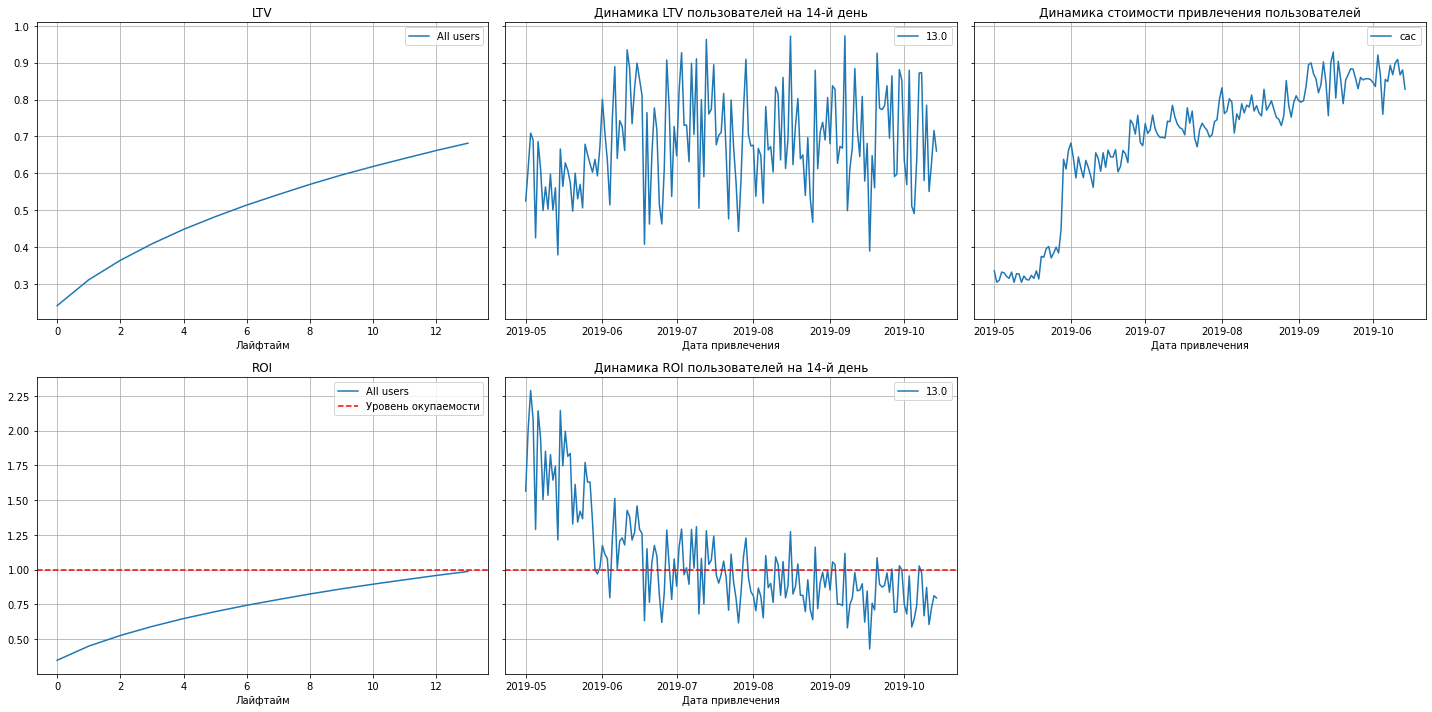

In [29]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
* Реклама не окупается. ROI в конце двухнедельного периода стремится к уровню окупаемости, то есть компани работает без прибыли. Пользователи окупают только свое привлечение. 
* CAC нестабилен. Рекламный бюджет увеличивается более , чем в 2 раза.
* LTV в динамике колеблется на уровне 0,6 - 0,8 , значит, дело не в ухудшении качества пользователей.
* Так как LTV и ROI увелчиваются со временем, это говорит о правильности расчетов. Поэтому логично, что с ростом CAC при постоянном LTV показатель ROI в динамике снижается.

Необходимо выяснить причину роста расходов на рекламу.

Так как 36% пользователей пришли "сами", и на них не тратится рекламный бюджет, то отразим их влияние на окупаемость компании, то есть сделаем расчет окупаемости без них.

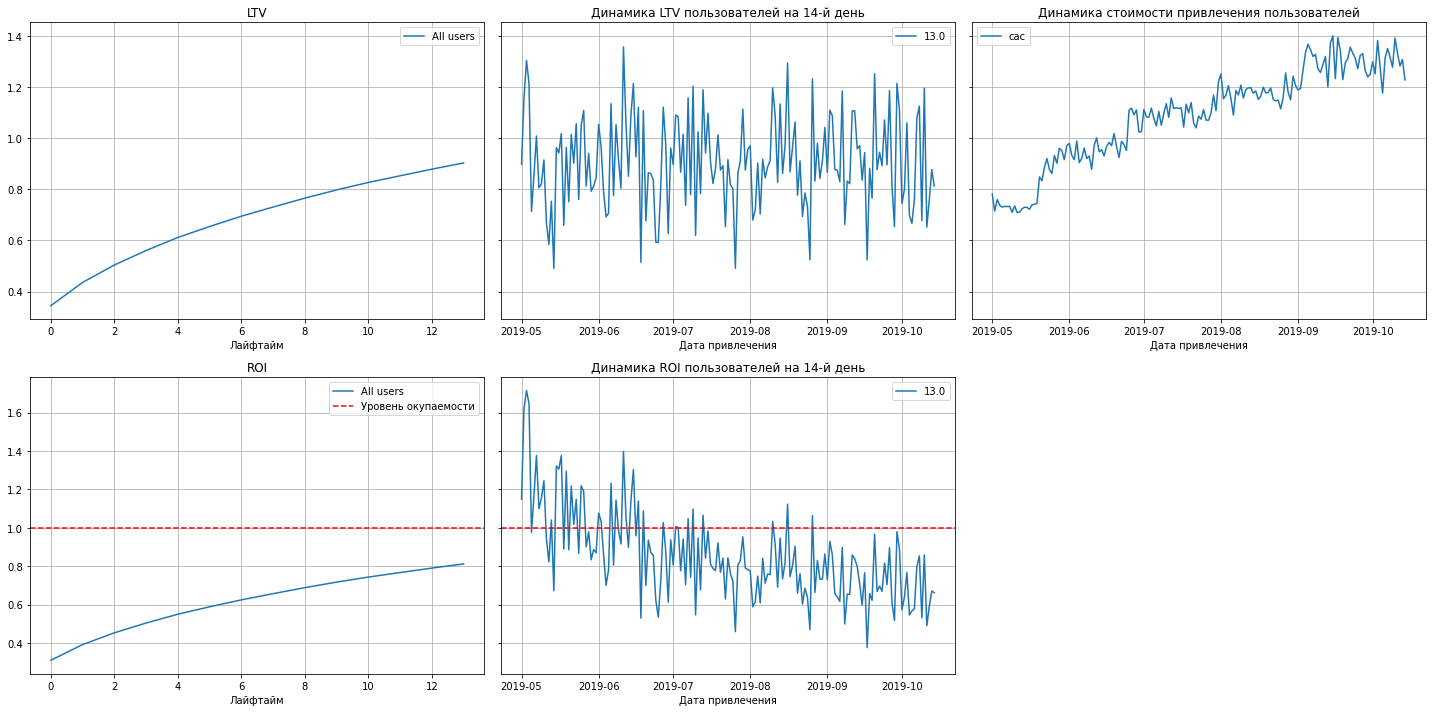

In [30]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    pure_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Видим, что окупаемость не достигается вообще.

Сравнивая графики по всем пользователям и без "органических", видим:
* Реклама не окупаетсявообще. на периоде оценки в 14 дней. То есть выйти к точке безубыточности компании удавалось только благодаря покупкам пользователей, пришедших самостоятельно.
* CAC нестабилен. Рекламный бюджет увеличивается более , чем в 2 раза.
* LTV в динамике колеблется на уровне 0,8 - 1.2,что выше, чем по всем пользователям,  значит, "платные" пользователи приносят больше прибыли, чем "бесплатные".
* LTV общий растет до 0,9, в отличие от общего LTV (0,7), что  еще раз говорит о том, что привлеченные пользователи платят больше.
* Так как LTV и ROI увелчиваются со временем, это говорит о правильности расчетов. Поэтому логично, что с ростом CAC при постоянном LTV показатель ROI в динамике снижается.

### Анализ общей окупаемости рекламы с разбивкой по устройствам

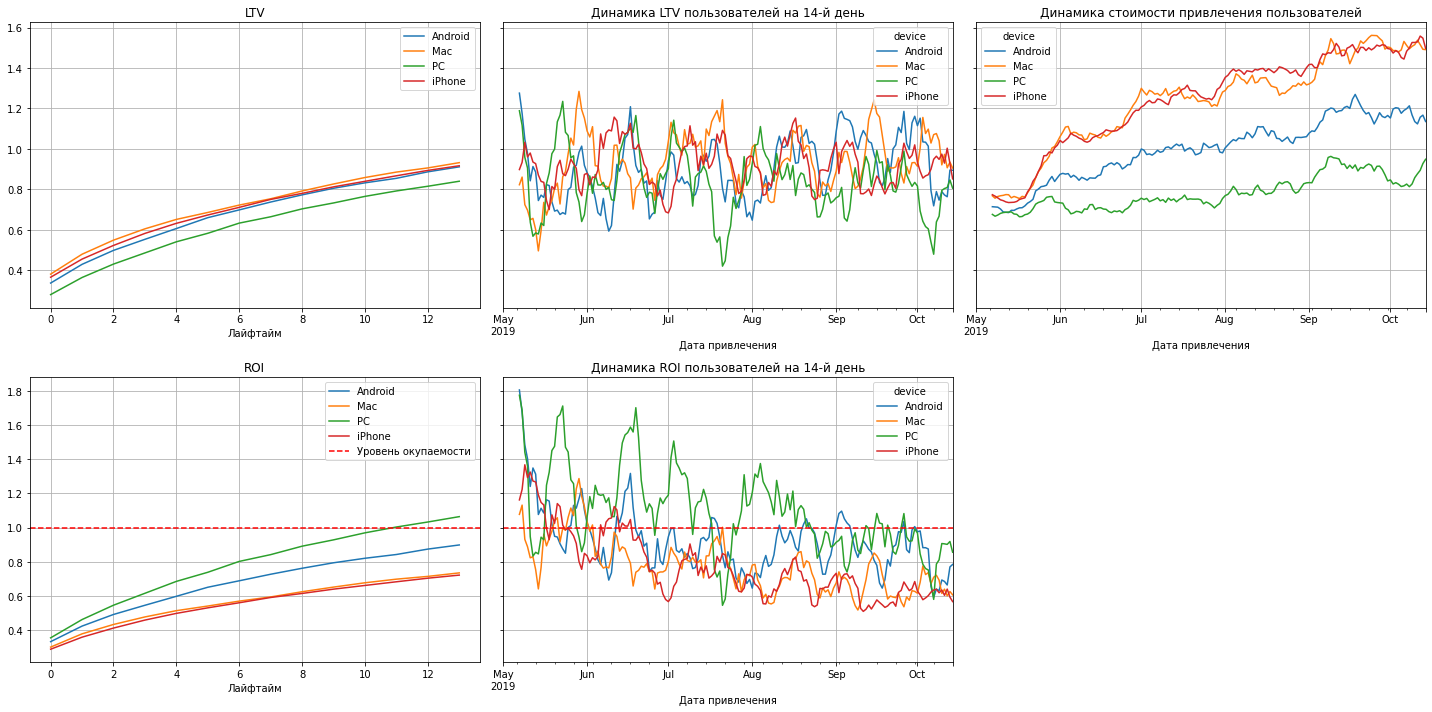

In [31]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    pure_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
) 

По графикам можно сделать такие выводы:

* Реклама окупается по устройствам PC на 12-й день. У дорогих устройств Iphone  и Mac реклама не окупается.
* САС резко возрастает в июне 2019 и продолжает рост от месяца к месяцу. У устройств PC, Android динамика роста затрат на рекламу выражена меньше, чем у Iphone  и Mac.
* LTV в динамике колеблется на уровне 0,7 - 1.1 , значит, дело не в ухудшении качества пользователей на разных устройствах.
* Так как LTV и ROI увелчиваются со временем, это говорит о правильности расчетов. Поэтому логично, что с ростом CAC при постоянном LTV показатель ROI в динамике снижается.Однако ROI у РС в большинстве периодов превышает уровень окупаемости.

Необходимо выяснить, с чем связан резкий рост расходов на рекламу в июне.

### Анализ общей окупаемости рекламы с разбивкой по странам

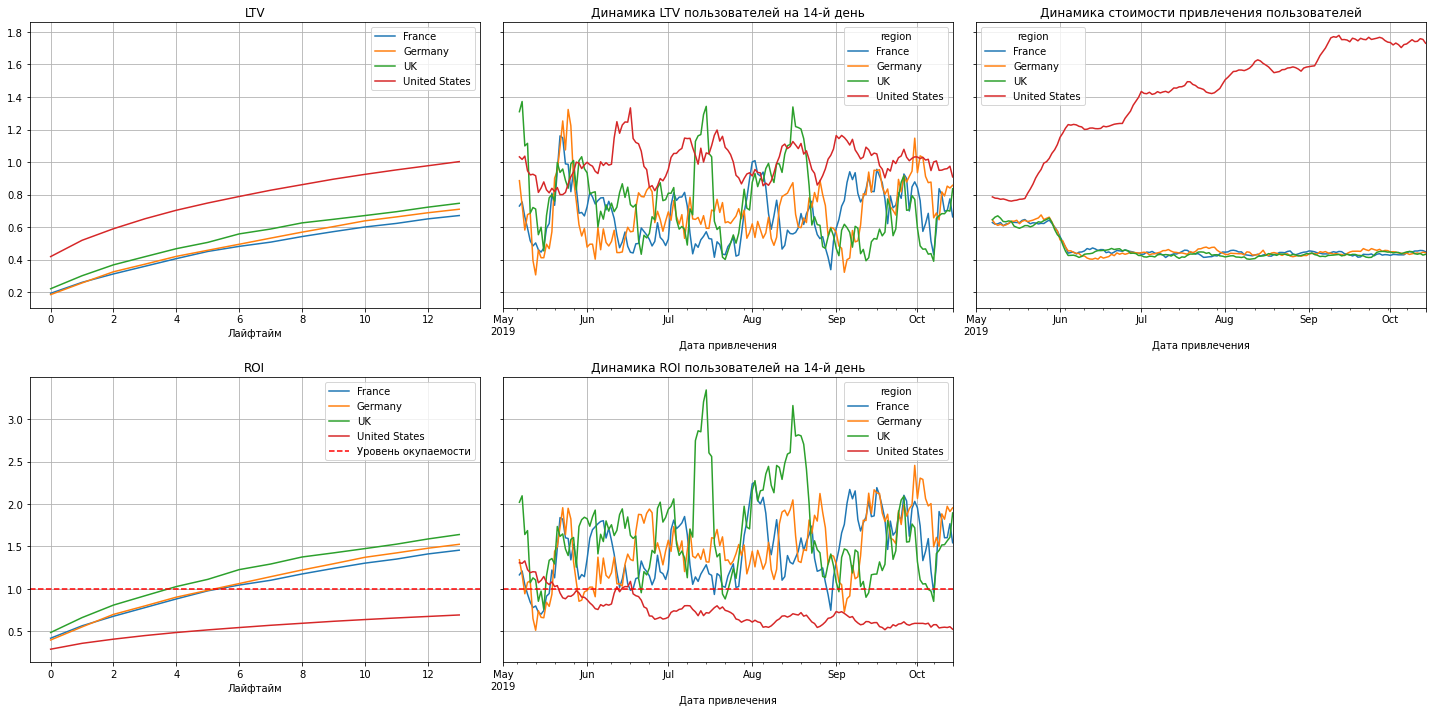

In [32]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    pure_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
) 

Вот что говорят графики:
* Реклама окупается на 5-7 день по всем странам (UK, France, Germany) кроме US.
* Наиболее высокий LTV у US, то есть клиенты из США приносят наибольшую прибыль. Наименьшую прибыль приносят клиенты из Франции.
* Динамика LTV подвержена сезонности, но стабильна.
* САС стабильна по всем странам (UK, France, Germany) кроме US. По США размер рекламных расходов начинает расти с середины мая, а далее увеличивается в несколько раз с 0,7 до 1,8, почти в 3 раза.
* Динамика ROI положительна для всех стран до середины июня, после чего по США ROI не достигает уровня окупаемости.

Необходимо разобраться в том, почему расходы на рекламу так сильно возрастают у США с середины мая.

### Анализ общей окупаемости рекламы с разбивкой по рекламным каналам

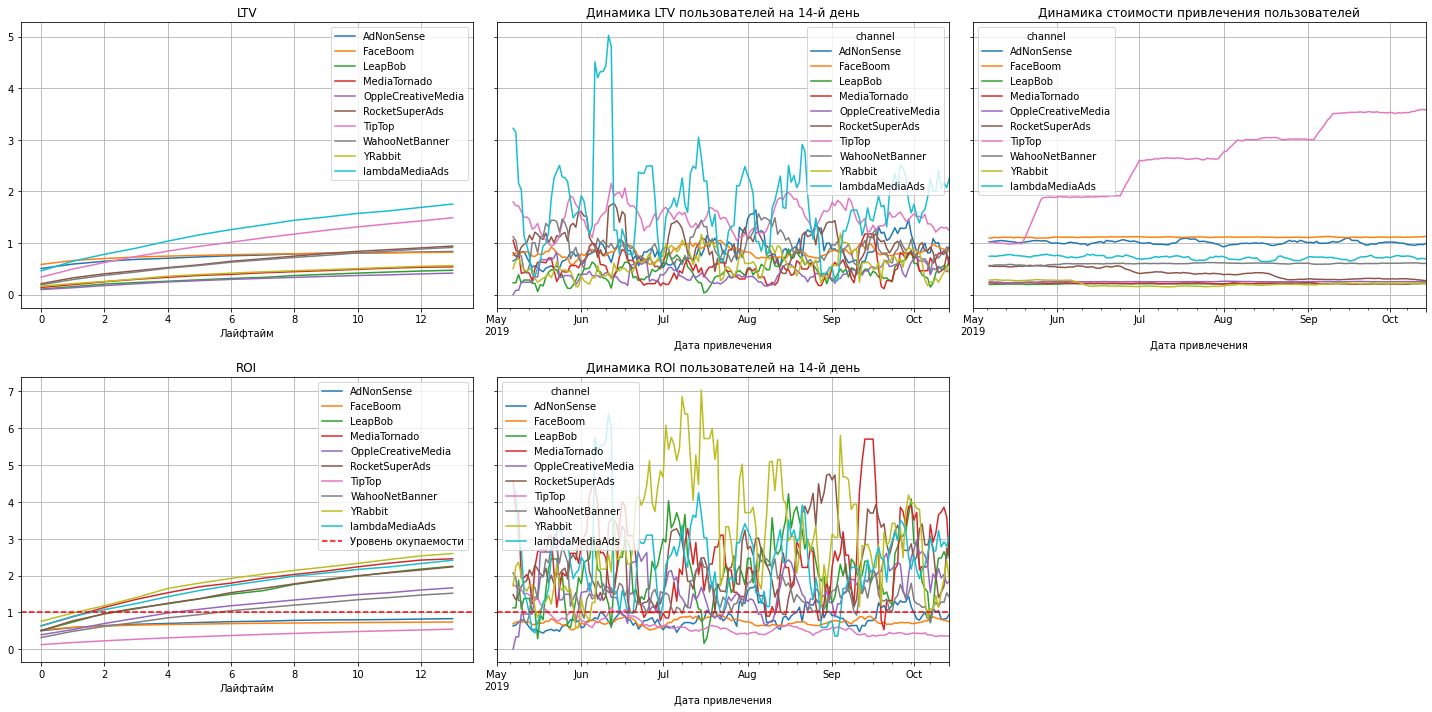

In [33]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    pure_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
) 

По графикам видим:
* Затраты на привлечение не окупаются по каналам TipTop,FaceBoom,AdNoneSense.Остальные каналы окупаютс с 3-го по 6-й день после привлечения пользователя через соответсвующий канал. Лучше всего окупаются каналы YRabbit,MediaTornado, lambdaMediaAds.
* По динамике ROI во всех периодах не окупается TipTop,FaceBoom. Практически всегда не окупается AdNoneSense. Остальные каналы привлечения окупаются в динамике.
* Наибольшую прибыль приносят каналы lambdaMediaAds,TipTop.Наименьшая прибыль у органического привлечения.
* Стоимость привлечения сильно возрастает с середины мая у канала TipTop. САС у других каналов постоянна. 
* Наиболее высокие затраты САС у каналов FaceBoom,AdNoneSense,lambdaMediaAds. Наименьшие затраты на привлечение у YRabbit,MediaTornado.

Необходимо выяснить, причины кратного роста стоимости привлечения с середины мая у канала TipTop.

Промежуточные выводы по компании в целом:

Рекламные расходы равняются выручке только к концу периода в 14 дней. Отмечаем сильный рост расходов на привлечение, а следствие - снижение ROI.

При анализе окупаемости рекламы по параментрам:
* Устройства. CAC растет у всех. Не окупаются у Iphone и Mac.
* Страны. Реклама не окупается у США, хотя там самые "прибыльные" пользователи.
* Каналы.Кратный рост стоимости привлечения с середины мая у канала TipTop.

Выводим, что необходимо лучше проанализировать данные по США, каналу TipTop на устройствах Iphone, Mac, Android.

Для этого проанализируем метрики конверсии и удержания по параметрам.

### Анализ показателей конверсии и удержания

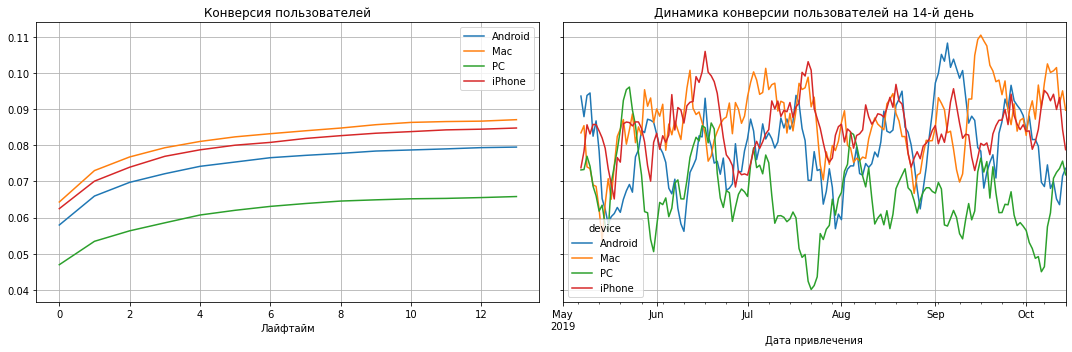

In [34]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    pure_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,window=7) 


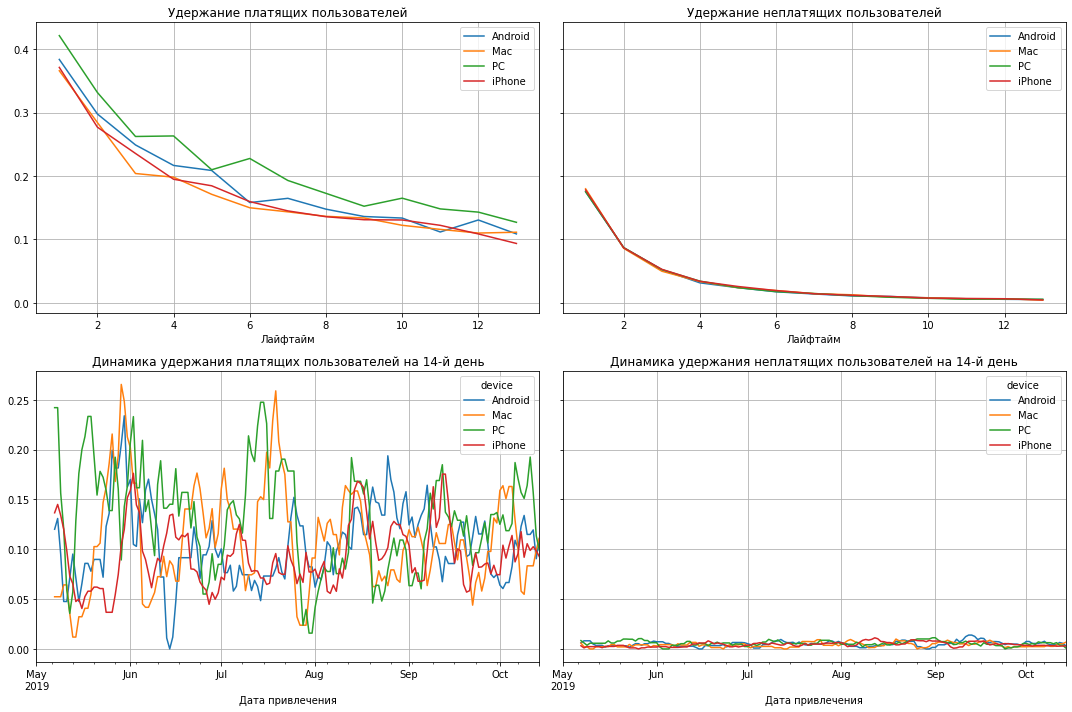

In [35]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    pure_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=7)

Ничего удивительного в конверсии и удержании по типам устройств не находим. Как и писали ранее, самые прибыльные устройства - IPhone, Mac, но удерживать пользователей их сложнее.

Определим конверсию и удержание в разрезе стран.

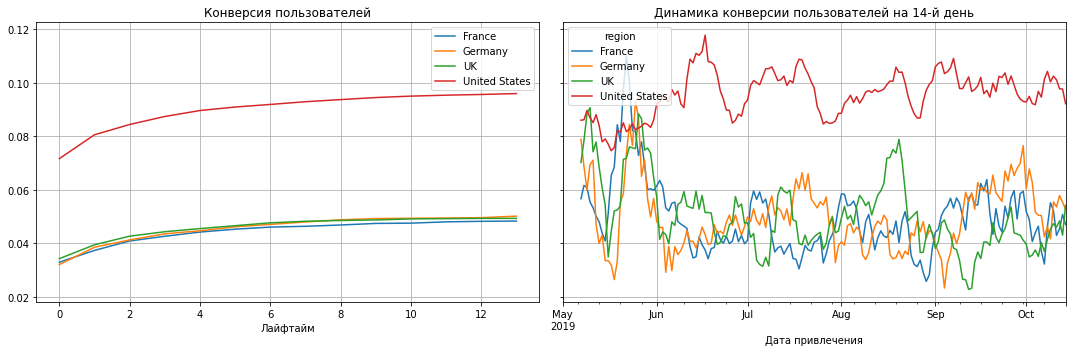

In [36]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    pure_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,window=7) 


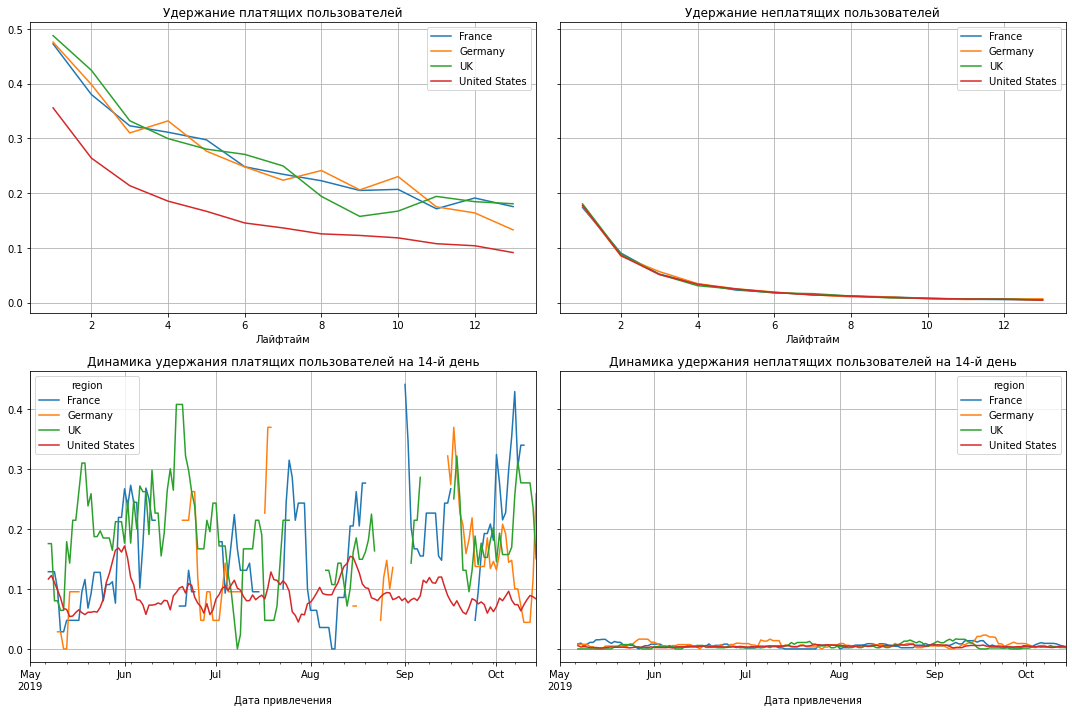

In [37]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    pure_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days,window=7)

Пользователи из США лучше всех платят, но хуже всех удерживаются.

Определим конверсию и удержание в разрезе каналов привлечения.

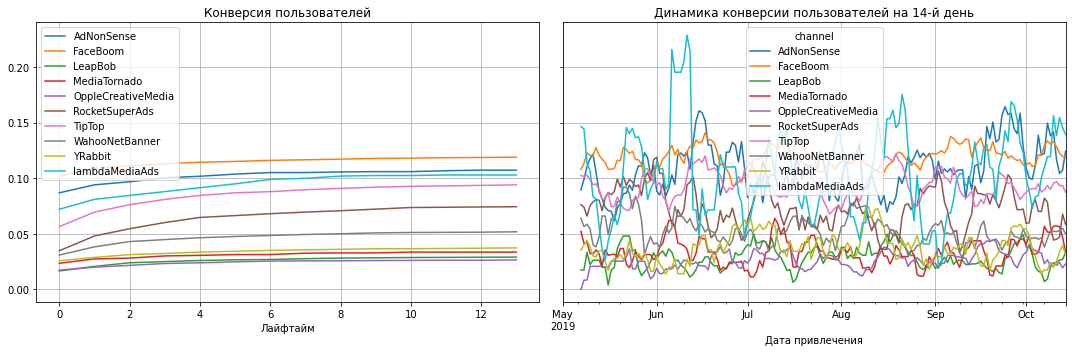

In [38]:
# смотрим конверсию с разбивкой по каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    pure_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,window=7) 


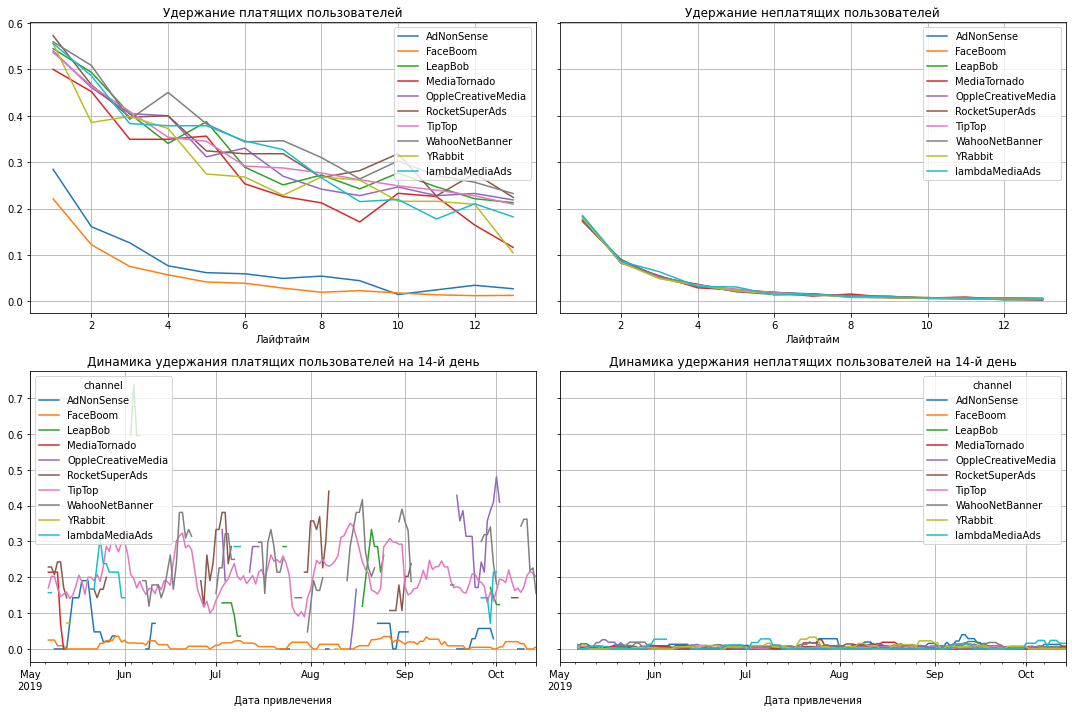

In [39]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    pure_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days,window=7)

По каналам AdNonSense и FaceBoom - наихудшее удержание. Это может быть связано с конкурированием каналов между собой, настройкой их на одни и те же целевые аудитории или пользователи у этих каналов одни.

Так как главные рекомендации состоят в снижении расходов на привлечение по стране США, каналу TipTop на устройствах Iphone, Android и Mac.


Рассчитаем стоимость привлечения пользователя по всем параметрам, отобрав те, где acquisition_cost больше средней. 

In [40]:
cac_profiles=pure_profiles.groupby(['region','channel', 'device']).agg({'user_id':'nunique','acquisition_cost':'mean' , 'revenue_sum':'sum'})\
                .sort_values('acquisition_cost', ascending=False).rename(columns={'user_id':'count_user'})
cac_profiles['channel_cost']=cac_profiles['count_user']*cac_profiles['acquisition_cost']
cac_profiles['financial result']=cac_profiles['revenue_sum']-cac_profiles['channel_cost']


display(cac_profiles.query('acquisition_cost >= @total_cac'))

count_user  acquisition_cost  revenue_sum  \
region        channel  device                                               
United States TipTop   PC             1844             2.759     7405.490   
                       Mac            4427             2.747    14773.990   
                       Android        3564             2.726    15475.240   
                       iPhone         8118             2.723    30000.750   
              FaceBoom Android        5400             1.114     5201.400   
                       PC             2751             1.114     2432.430   
                       Mac            6678             1.114     6004.100   
                       iPhone        11907             1.114    10069.550   

                                channel_cost  financial result  
region        channel  device                                   
United States TipTop   PC           5088.339          2317.151  
                       Mac         12163.091          2610.899  
                       Android      9713.935          5761.305  
                       iPhone      22108.936          7891.814  
              FaceBoom Android      6014.420          -813.020  
                       PC           3064.011          -631.581  
                       Mac          7436.988         -1432.888  
                       iPhone      13259.381         -3189.831

Над всеми параметрами по странам, каналу привлечения, которые выше среднего , необходимо работать, проверять настройки рекламных запусков, снижать затраты, выбирать другие способы оплаты рекламы.

## Шаг 6. Выводы


Причины неэффективности привлечения пользователей и рекомендации:

* ориентироваться в выборе каналов продвижения на долю платящих пользователей. Так, у Германии доля платящих пользователей больше, чем у Франции и Англии, но на них трафик выше.
* наибольшее число оплат на устройствах  Mac (6,4%), iPhone (6,2%). Значит, делать продукт сначала для этих устройств, потом для остальных.
* Основной источник трафика - органический. Значит, приложение очень полезное. Им охотно делятся с друзьями и знакомыми. Но оплат крайне мало.Получается, что пользователям в большинстве случаев хватает бесплатного функционала. Поэтому маркетологам необходимо подумать над дополнительными платными функциями, которые будут интересны пользователям, пришедшим органически. Причем средний чек такой же, как у всех пользователей.

* Кратный рост стоимости привлечения с середины мая у канала TipTop. Разобраться в причинах роста стоимости.
* Лучше всего окупаются каналы YRabbit,MediaTornado, lambdaMediaAds. Обратить на них внимание, настроить на них трафик.
* Сделать разную стоимость продукта для разной локаций, так как средняя стоимость продукта всего 5,37 у.е., а медианная 4,99 у.е., то есть имеет место много мелких чеков. 
* увеличивать средний чек, комбинируя разные предложения, тарифы продукта.


In [41]:
orders['revenue'].describe()

count   40212.000
mean        5.371
std         3.454
min         4.990
25%         4.990
50%         4.990
75%         4.990
max        49.990
Name: revenue, dtype: float64